# Classification Trees
This notebook will focus on hyperparameter tuning of various tree-based normals, among their scoring and comparison. They will be scored employing various relevant metrics, so that they valuable insights can be obtained from the comparison.\
**Single tree, bagging, boosting, random forest.**\
In this iteration, we will use the same data that was used to train the baseline performance from the single tree model in *importance_analysis.ipynb*. 

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, RepeatedStratifiedKFold


In [3]:
# Import the dataframe cleaned and encoded during the feature importance process.
df_encoded = pd.read_csv('../data/df_encoded.csv')

In [8]:
df_encoded.head(1)

,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBARatio,NAICS_i_0,NAICS_i_11,NAICS_i_21,...,NAICS_i_61,NAICS_i_62,NAICS_i_71,NAICS_i_72,NAICS_i_81,NAICS_i_92,UrbanRural_0,UrbanRural_1,UrbanRural_2,Default
0,84,1.0,0,0,1,60000.0,0.8,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [6]:
target = 'Default'
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
# Our target and features are the same that we employed during the importance analysis.
print(f"Target: {target}")
print(f"Features: {features_encoded}")

Target: Default
Features: ['Term', 'isNewBusiness', 'isFranchise', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBARatio', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [12]:
# This split will be used in every model, so that they are scored against the same subset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)

### Single tree


In [14]:
from sklearn.tree import DecisionTreeClassifier

# Grid of parameters for a single tree
param_grid = [
    {
        "min_samples_split": [150, 200, 250, 400, 500],
        "max_depth": [12, 14, 16, 18, 20]
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingGridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

single_tree_search.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 87051
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 87051
Fitting 9 folds for each of 25 candidates, totalling 225 fits
----------
iter: 1
n_candidates: 9
n_resources: 261153
Fitting 9 folds for each of 9 candidates, totalling 81 fits
----------
iter: 2
n_candidates: 3
n_resources: 783459
Fitting 9 folds for each of 3 candidates, totalling 27 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=DecisionTreeClassifier(), n_jobs=-1,
                    param_grid=[{'max_depth': [12, 14, 16, 18, 20],
                                 'min_samples_split': [150, 200, 250, 400,
                                                       500]}],
                    scoring='recall', verbose=1)

In [19]:
# Function to obtain the top scored hyperparam combinations
def best_params(search: HalvingGridSearchCV):
    results_df = pd.DataFrame(single_tree_search.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    return results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [26]:
# Let's see the results of the single tree
best_params(single_tree_search).head(5)


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
16_150,"{'max_depth': 16, 'min_samples_split': 150}",1,0.790930,0.003381
14_150,"{'max_depth': 14, 'min_samples_split': 150}",2,0.789984,0.002939
18_150,"{'max_depth': 18, 'min_samples_split': 150}",3,0.789686,0.003961
16_150,"{'max_depth': 16, 'min_samples_split': 150}",4,0.778994,0.004971
14_150,"{'max_depth': 14, 'min_samples_split': 150}",5,0.778968,0.005806


In [35]:
# Let's use the best estimator to obtain test and overall scores 
single_tree_model = single_tree_search.best_estimator_

yhat_test = single_tree_model.predict(X_test)

metrics_test = [
    recall_score(yhat_test, y_test),
    precision_score(yhat_test, y_test),
    roc_auc_score(yhat_test, y_test),
    f1_score(yhat_test, y_test)
]

single_tree_test_metrics = pd.DataFrame(
    [metrics_test], 
    columns = ['Recall', 'Precision', 'ROC', 'F1'], 
    index=['Single Tree Test']
)

single_tree_test_metrics

,Recall,Precision,ROC,F1
Single Tree Test,0.829272,0.794212,0.893409,0.811363


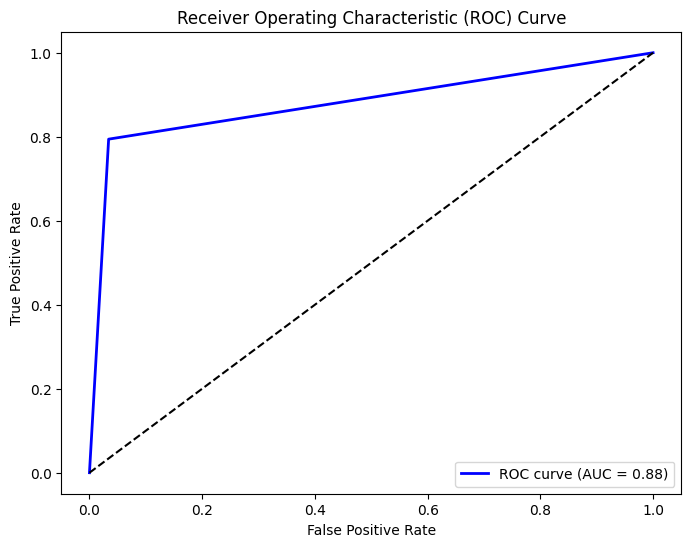

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

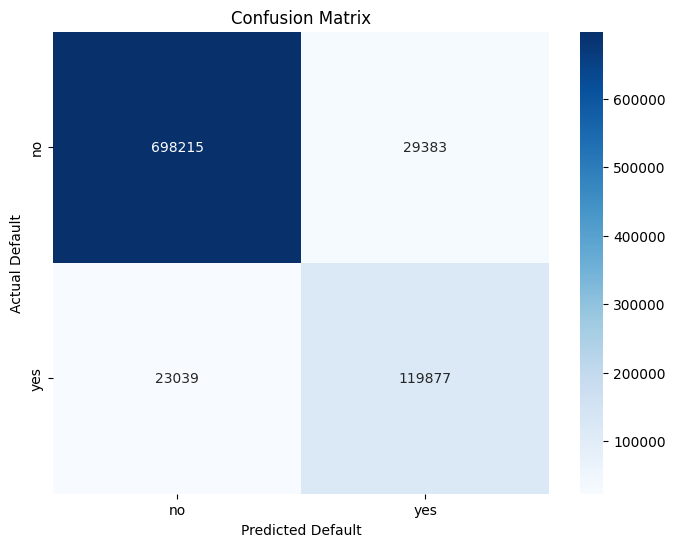

In [41]:
# Calculate the confusion matrix
yhat_total = single_tree_model.predict(df_encoded[features_encoded])
cm = confusion_matrix(yhat_total, df_encoded[target])

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix')
plt.show()


## Bagging

In [45]:
from sklearn.ensemble import BaggingClassifier

# Grid of parameters for a single tree
param_grid = [
    {
        "estimator__min_samples_split": [150, 200, 250, 400, 500],
        "estimator__max_depth": [12, 14, 16, 18, 20],
        "n_estimators": [10, 100, 500]
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingGridSearchCV(
    estimator=BaggingClassifier(DecisionTreeClassifier()),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

single_tree_search.fit(X_train, y_train)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 29017
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 75
n_resources: 29017
Fitting 9 folds for each of 75 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 25
n_resources: 87051
Fitting 9 folds for each of 25 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 9
n_resources: 261153
Fitting 9 folds for each of 9 candidates, totalling 81 fits
----------
iter: 3
n_candidates: 3
n_resources: 783459
Fitting 9 folds for each of 3 candidates, totalling 27 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
                    n_jobs=-1,
                    param_grid=[{'estimator__max_depth': [12, 14, 16, 18, 20],
                                 'estimator__min_samples_split': [150, 200, 250,
                                                                  400, 500],
                                 'n_estimators': [10, 100, 500]}],
                    scoring='recall', verbose=1)

In [46]:
# Let's see the results of the bagging model
best_params(single_tree_search).head(5)


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
18_150_100,"{'estimator__max_depth': 18, 'estimator__min_s...",1,0.794327,0.002604
16_150_500,"{'estimator__max_depth': 16, 'estimator__min_s...",2,0.793775,0.002297
16_150_10,"{'estimator__max_depth': 16, 'estimator__min_s...",3,0.792931,0.002349
18_150_100,"{'estimator__max_depth': 18, 'estimator__min_s...",4,0.775478,0.004622
16_150_500,"{'estimator__max_depth': 16, 'estimator__min_s...",5,0.774755,0.004575


# Other stuff

In [9]:
# Grid search
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {
        "min_samples_split": [50, 100],
        "max_depth": [20, 30, 40],
        "n_estimators": [100, 200]
    }
]

# Let's also try some CV



X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

search = HalvingGridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

# X_train, X_test, y_train, y_test = train_test_split(df_encoded[features], df_encoded[target], train_size = .9)
# from sklearn.model_selection import RepeatedStratifiedKFold
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3)

# search = GridSearchCV(estimator=RandomForestClassifier(), 
#                       param_grid=param_grid, 
#                       scoring='accuracy', 
#                       cv=cv,
#                       n_jobs=-1)
# search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 87051
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 87051
Fitting 9 folds for each of 12 candidates, totalling 108 fits
----------
iter: 1
n_candidates: 4
n_resources: 261153
Fitting 9 folds for each of 4 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 2
n_resources: 783459
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42),
                    estimator=RandomForestClassifier(), n_jobs=-1,
                    param_grid=[{'max_depth': [20, 30, 40],
                                 'min_samples_split': [50, 100],
                                 'n_estimators': [100, 200]}],
                    scoring='precision', verbose=1)

In [ ]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [ ]:
yhat_test = search.best_estimator_.predict(X_test)
print(y_test.shape)
print(accuracy_score(yhat_test, y_test))

In [ ]:
len(df[df[target] == 1])/len(df)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, yhat_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
yhat_train = search.best_estimator_.predict(X_train)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_train, yhat_train)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['yes', 'no'], yticklabels=['yes', 'no'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# I am sure that more estimators is generating better results.

rfmodel = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    min_samples_split=50,
    n_jobs=-1,
    verbose=1
).fit(df_encoded[features], df_encoded[target])

In [ ]:
# Calculate the confusion matrix
yhat_rf = rfmodel.predict(df_encoded[features])
cm = confusion_matrix(df_encoded[target], yhat_rf)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['yes', 'no'], yticklabels=['yes', 'no'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

xgb_model.fit(df_encoded[features], df_encoded[target])